Side note: all the cells until the `Pipelining Preprocessing Steps` are similar to the cells in `...phase_1.ipynb` file, as we've worked on preprocessing steps to be used in phase 2 when writing the code for phase 1

# Cells for Google Colab

In [1]:
import os
runningFromColab = False
if 'CGROUP_MEMORY_EVENTS' in os.environ and 'colab' in os.environ['CGROUP_MEMORY_EVENTS']:
  runningFromColab = True

In [2]:
if runningFromColab:
  from google.colab import drive
  drive.mount('/content/drive')

In [3]:
if runningFromColab:
  %cd /content/drive/MyDrive/ColabProjects

In [4]:
if runningFromColab:
  !git clone https://github.com/OdyAsh/nlp-image-captioning.git

In [5]:
if runningFromColab:
  %cd /content/drive/MyDrive/ColabProjects/nlp-image-captioning

In [6]:
if runningFromColab:
  !git pull
  # if it DOES NOT say "Already up to date.", then you need to close this notebook file (i.e., the browser tab) and open it again for it to change 

In [7]:
# if runningFromColab:
#   try:
#     import condacolab
#     condacolab.install()
#   except:
#     !pip install -q condacolab
#     import condacolab
#     condacolab.install()
#     # now restart the kernel

In [8]:
# if runningFromColab:
#   !conda env create -f environment.yml
#   # !conda update conda -y -q
#   # !source /usr/local/etc/profile.d/conda.sh
#   # !conda init 
#   # !conda install -n root _license -y -q
#   # !source activate myenv

In [9]:
# if runningFromColab:
#   import sys
#   sys.path.insert(0, '/usr/local/bin/conda')

# Imports & Global Functions/Variables

In [10]:
from pprint import pprint
from glob import glob
from time import time
import os
import pickle
import regex as re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import keras
# import tensorflow as tf
# # hide gpu
# tf.config.set_visible_devices([], 'GPU')

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
#                          Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
# from tensorflow.keras.layers import Bidirectional
# from tensorflow.keras.layers import Add # merge.add
from tensorflow.keras.applications import inception_v3 # inception_v3.preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import preprocessing # preprocessing.image, preprocessing.sequence, preprocessing.text.Tokenizer, preprocessing.sequence.pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    return content

def pklForceLoad(path, dtype = 'dict'):
    try:
        content = pklLoad(path)
        return content
    except Exception as e:
        if dtype == 'list':
            pklSave([], path)
            return []
        else:
            pklSave({}, path)
            return {}

# more about naming standards for path components here: https://stackoverflow.com/questions/2235173/what-is-the-naming-standard-for-path-components
def joinPaths(baseDirectory, relativePath):
    return os.path.normpath(os.path.join(baseDirectory, relativePath))

In [13]:
datasetImgsBasePath = 'dataset/Flicker8k_Dataset/'
fullImgsPath = glob(datasetImgsBasePath + '*.jpg')
fullImgsPaths = [os.path.normpath(path) for path in fullImgsPath]
len(fullImgsPaths)

8091

# Data Collection
The dataset is obtained from [here](https://forms.illinois.edu/sec/1713398)

In [14]:
# checking the 5 captions per image
filename = "dataset/Flicker8k_TextFiles/Flickr8k.token.txt"
with open(filename, 'r') as f:
    doc = f.read()
lines = doc.split('\n')
print('first image\'s captions:')
pprint(lines[:5])
print('\nattention image\'s captions:')
pprint(lines[5:10])
print('\nand so forth...')

first image's captions:
['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of '
 'stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse '
 '.',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her '
 'playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a '
 'wooden cabin .']

attention image's captions:
['1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with '
 'each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots '
 'are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each '
 'other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

an

The captions above are for these two images:

<img src="project_media/1000268201_693b08cb0e.jpg" width="100" />

<img src="project_media/1001773457_577c3a7d70.jpg" width="150" />

# Data Cleaning
Includes:
* `imgToCaptions` dictionary
* `cleanCaptions()` to remove stopwords/punctuations
* `createVocab()` to limit vocab size based on word frequency
* `train`, `val`, and `test` `ImgToCaptions` which prepends `startseq` and appends `endseq`

In [15]:
# getting these captions in a dictionary; 
# where the key is the image's name (without .jpg) and the value is a list of 5 captions

imgToCaptions = dict()
for line in lines:
    idAndCaption = re.split("\..+\t", line)
    if len(idAndCaption) < 2:
        continue
    imgId, caption = idAndCaption
    if imgId not in imgToCaptions:
        imgToCaptions[imgId] = list()
    imgToCaptions[imgId].append(caption)
    
imgToCaptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# removing punctuation using maketrans (i.e., translation table)
# more about maketrans method: https://www.w3schools.com/python/ref_string_maketrans.asp#:~:text=The%20third%20parameter%20in%20the%20mapping%20table%20describes%20characters%20that%20you%20want%20to%20remove%20from%20the%20string%3A


def cleanCaptions(imgToCaptions, levelOfStopwordsPresence=1):
    table = str.maketrans('', '', string.punctuation) # third argument: removes any character in this list: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for key, descList in imgToCaptions.items():
        # when this for loop is done, all 5 captions of an image will be cleaned
        for i in range(len(descList)):
            desc = descList[i]
            desc = desc.split(' ')
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc] # remove punctuation from each token
            stopswordsToRemove = []
            if levelOfStopwordsPresence == 1:
                stopswordsToRemove = ['a', 'an', 'the']
            elif levelOfStopwordsPresence >= 2:
                stopswordsToRemove = set(stopwords.words('english'))
            desc = [word for word in desc if word not in stopswordsToRemove]
            desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
            descList[i] =  ' '.join(desc) # store as string

# cleanCaptions(imgToCaptions, levelOfStopwordsPresence=1)
# pklSave(imgToCaptions, 'dataset/pickles/imgToCaptionsSWKept.pickle')
imgToCaptions = pklLoad('dataset/pickles/imgToCaptionsSWKept.pickle')
imgToCaptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

example with stopwords removed:
<br><br>
'little girl climbing stairs playhouse',

<br>
example with only ['a', 'an', 'the'] removed:
<br><br>
'little girl climbing stairs to her playhouse',
<br><br>
from the lack of context seen above, we've decided to keep the rest of the stopwords

In [17]:
# creating vocab of unique words (where each word occured at least freqThreshold number of times)
def createVocab(imgToCaptions, freqThreshold = 10):
    vocab = set()
    for key in imgToCaptions.keys():
        [vocab.update(desc.split()) for desc in imgToCaptions[key]]
    print(f'Original vocabulary (i.e., unique words) size: {len(vocab)}')

    # keeping words that appear at least freqThrehold number of times
    vocabWordFreq = {key: 0 for key in vocab}
    for key, descs in imgToCaptions.items():
        for desc in descs:
            descList = desc.split(' ')
            for word in descList:
                if word != '':
                    vocabWordFreq[word] += 1
    
    vocab = set()
    i = 0
    for word, freq in vocabWordFreq.items():
        if freq >= freqThreshold:
            i += 1
            vocab.add(word)
            vocabWordFreq[word] = freq
    print(f'Vocabulary size after removing less frequent words (< {freqThreshold} words): {len(vocab)}')

    vocabWordFreqRemoved = {word: freq for word, freq in vocabWordFreq.items() if word not in vocabWordFreq}

    return vocab, vocabWordFreq, vocabWordFreqRemoved

def createVocabTxtFiles(vocabWordFreq, vocabWordFreqRemoved, filePrefix="vocabFreqThreshold"):
    with open(f'dataset/{filePrefix}.txt', 'w') as f:
        f.write(str(dict(sorted(vocabWordFreq.items(), key=lambda x: x[1], reverse=True))))
    with open(f'dataset/{filePrefix}Removed.txt', 'w') as f:
        f.write(str(dict(sorted(vocabWordFreqRemoved.items(), key=lambda x: x[1], reverse=True))))

freqThreshold = 5
vocab, vocabWordFreq, vocabWordFreqRemoved = createVocab(imgToCaptions, freqThreshold)
createVocabTxtFiles(vocabWordFreq, vocabWordFreqRemoved, filePrefix=f"vocabFreqThreshold{freqThreshold}")

Original vocabulary (i.e., unique words) size: 8366
Vocabulary size after removing less frequent words (< 5 words): 2945


In [18]:
# function to get filenames of images from a text file (without the extension)
def getImgsIdsList(txtPath):
    with open(txtPath, 'r') as f:
        doc = f.read()
    ImgsIds = []
    for line in doc.split('\n'):
        imgId = line.split('.')[0]
        ImgsIds.append(imgId)
    ImgsIds = [id for id in ImgsIds if id != '']
    return ImgsIds

trainImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.trainImages.txt')
valImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.devImages.txt')
testImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.testImages.txt')
print(f'Train Dataset: {len(trainImgsIds)}')
print(f'Validation Dataset: {len(valImgsIds)}')
print(f'Test Dataset: {len(testImgsIds)}')

Train Dataset: 6000
Validation Dataset: 1000
Test Dataset: 1000


In the code below, we use `startseq` and `endseq` for the following reasons:
* startseq : Will indicate the start of the caption generation process
* endseq : to stop predicting words as soon as it appears

In [19]:
trainImgToCaptions = dict()
valImgToCaptions = dict()
testImgToCaptions = dict()
for imgId in trainImgsIds:
    trainImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
for imgId in valImgsIds:
    valImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
for imgId in testImgsIds:
    testImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
print(f'images in training set: {len(trainImgToCaptions)}\n')
print(f'images in validation set: {len(valImgToCaptions)}\n')
print(f'images in testing set: {len(testImgToCaptions)}\n')
print('example from training set:')
pprint(trainImgToCaptions['2513260012_03d33305cf'])

images in training set: 6000

images in validation set: 1000

images in testing set: 1000

example from training set:
['startseq black dog is running after white dog in snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across snowy ground endseq',
 'startseq two dogs play together in snow endseq',
 'startseq two dogs running through low lying body of water endseq']


# Preparing File Paths

In [20]:
trainImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in trainImgToCaptions.keys()]
valImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in valImgToCaptions.keys()]
testImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in testImgToCaptions.keys()]
len(trainImgsPaths), len(valImgsPaths), len(testImgsPaths)

(6000, 1000, 1000)

# Data Pre-Processing
Includes:
* Pre-Processing Images
* Pre-Processing Captions

## Pre-Processing Images
Includes:
* Loading Google's `InceptionV3` model
* Preprocessing the image
* Encoding the image by inputting it to `InceptionV3` to get a `2048` feature vector of the image

In [21]:
# getting the feature vector of each image using the InceptionV3 CNN model created by Google Research
inception_model = InceptionV3(weights='imagenet') # getting the InceptionV3 model trained on imagenet data
inception_model.layers[-1].output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [22]:
modelForFeatureExtraction = Model(inception_model.input, inception_model.layers[-2].output) # removing the last layer (output softmax layer)
modelForFeatureExtraction.layers[-1].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [23]:
# function to preprocess the input image
def preprocess(imgPath):
    pilImg = preprocessing.image.load_img(imgPath, target_size=(299, 299)) # Convert all the images to size 299x299 as expected by the inception v3 model
    x = preprocessing.image.img_to_array(pilImg) # Convert PIL image to numpy array of 3-dimensions
    x = np.expand_dims(x, axis=0) # Add one more dimension; from (299, 299, 3) to (1, 299, 299, 3)
    x = inception_v3.preprocess_input(x) # takes in (batch_size, height, width, channels), returns same dimensions, but does some preprocessing operations, like scaling values to be from -1 to 1
    return x

# function to encode a given image (from its path) into a vector of size (2048, )
def encode(imgPath, modelForFeatureExtraction):
    imgPath = preprocess(imgPath) # preprocess the image
    featureVec = modelForFeatureExtraction.predict(imgPath) # Get the encoding vector for the image
    featureVec = np.reshape(featureVec, featureVec.shape[1]) # reshape from (1, 2048) to (2048, )
    return featureVec

In [24]:
# Call the funtion to encode all the train images (dictionary where an image id --> feature vector of length 2048)
# This will take a while on CPU - Execute this only once (took around 13 minutes on my high-end laptop)
def encodeImgToFeatures(imgsPaths, modelForFeatureExtraction):
    imgToFeatures = dict()
    for imgPath in imgsPaths:
        imgToFeatures[imgPath[len(datasetImgsBasePath):]] = encode(imgPath, modelForFeatureExtraction)
    return imgToFeatures

# trainImgToFeatures = encodeImgToFeatures(trainImgsPaths, modelForFeatureExtraction)
# valImgToFeatures = encodeImgToFeatures(valImgsPaths, modelForFeatureExtraction)
# testImgToFeatures = encodeImgToFeatures(testImgsPaths, modelForFeatureExtraction)
# pklSave(trainImgToFeatures, 'dataset/pickles/trainImgToFeatures.pickle')
# pklSave(valImgToFeatures, 'dataset/pickles/valImgToFeatures.pickle')
# pklSave(testImgToFeatures, 'dataset/pickles/testImgToFeatures.pickle')
trainImgToFeatures = pklLoad('dataset/pickles/trainImgToFeatures.pickle')
valImgToFeatures = pklLoad('dataset/pickles/valImgToFeatures.pickle')
testImgToFeatures = pklLoad('dataset/pickles/testImgToFeatures.pickle')
len(trainImgToFeatures), len(valImgToFeatures), len(testImgToFeatures), trainImgToFeatures['2513260012_03d33305cf.jpg'].shape

(6000, 1000, 1000, (2048,))

## Pre-Processing Captions
Includes:
* `mapIdxAndWord()` to map indices to words and vice versa, where the words are obtained from `createVocab()`
* `maxCaptionLength()` to get the caption with the most amount of words, to be used later to pad input sequences <br> (explained in `Preparing Model Generator` section)

In [25]:
# creating two dictionaries: word to index, and index to word

def mapIdxAndWord(vocab):
    idxToWord = {}
    wordToIdx = {}
    idx = 1
    for word in vocab:
        wordToIdx[word] = idx
        idxToWord[idx] = word
        idx += 1
    return idxToWord, wordToIdx

vocab, _, _ = createVocab(imgToCaptions, freqThreshold=5)
idxToWord, wordToIdx = mapIdxAndWord(vocab)
vocabSize = len(idxToWord) + 1 # one for appended 0's; represents "startseq" (explained in "Preparing Model Generator" section)
vocabSize

Original vocabulary (i.e., unique words) size: 8366
Vocabulary size after removing less frequent words (< 5 words): 2945


2946

In [26]:
# getting the length of the longest caption; as we will later need to encode each word into a fixed sized vector

# convert a dictionary of clean captions to a list of captions
def toCaptionsList(ImgToCaptions):
	captionsList = list()
	for imgId in ImgToCaptions.keys():
		[captionsList.append(caption) for caption in ImgToCaptions[imgId]]
	return captionsList

# calculate the length of the description with the most words
def maxCaptionLength(ImgToCaptions):
    captions = toCaptionsList(ImgToCaptions)
    captionsLengths = [len(caption.split()) for caption in captions]
    return max(captionsLengths)

# determine the maximum sequence length
maxCapLen = maxCaptionLength(trainImgToCaptions)
print(f'Description Length: {maxCapLen}')

Description Length: 32


In [27]:
maxCaptionLength(testImgToCaptions)

29

# Word Embedding

## Using Glove Embedding

In [28]:
# run the commented code lines below once to create word_to_glove_embedding dictionary, then load it using pklLoad()
# Load Glove vectors
glove_dir = './dataset/glove_word_embeddings/'
# word_to_glove_embedding = {} # empty dictionary
# with open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8") as f:
#     for line in f:
#         word_and_embedding_of_word = line.split()
#         word = word_and_embedding_of_word[0]
#         coefs = np.asarray(word_and_embedding_of_word[1:], dtype='float32')
#         word_to_glove_embedding[word] = coefs
# pklSave(word_to_glove_embedding, './dataset/pickles/word_to_glove_embedding.pickle')

word_to_glove_embedding = pklLoad('./dataset/pickles/word_to_glove_embedding.pickle')

print('Found %s word vectors.' % len(word_to_glove_embedding))

Found 400000 word vectors.


In [29]:
def get_embedding_matrix(vocabSize, embedding_dim=200):
    # Get embedding_dim dense vector for each word in our vocabulary
    embedding_matrix = np.zeros((vocabSize, embedding_dim))

    words_with_no_embedding = []
    for word, i in wordToIdx.items():
        #if i < max_words:
        embedding_vector = word_to_glove_embedding.get(word)
        if embedding_vector is None:
            # Words not found in the embedding index will be all zeros
            words_with_no_embedding.append(word)
            continue
        embedding_matrix[i] = embedding_vector[:embedding_dim]

    return embedding_matrix, words_with_no_embedding

In [30]:
# for debugging: the code above will be re-written in preprocessing_pipeline()

#hyperparameter:
embedding_dim = 200 # Note: 200 is the maximum number of dimensions specified in glove.6B.200d.txt

embedding_matrix, words_with_no_embedding = get_embedding_matrix(vocabSize, embedding_dim)
print('number of words with no embeddings:', len(words_with_no_embedding))
print('which are:')
print(words_with_no_embedding)
print('embedding matrix dimensions (vocab size x embedding dimensions):')
print(embedding_matrix.shape)

number of words with no embeddings: 15
which are:
['surfboarder', 'inground', 'dalmation', 'waterskier', 'bicycler', 'plushie', 'parasails', 'wakeboards', 'rollerblader', 'wakeboarder', 'floaties', 'somthing', 'corndogs', 'windsurfs', 'outstreached']
embedding matrix dimensions (vocab size x embedding dimensions):
(2946, 200)


# Pipelining Preprocessing Steps

In [31]:
def preprocessing_pipeline(freq_threshold, model_for_feature_extraction, embedding_dim=200, load_features=False): # Note: in embedding_dim, 200 is the maximum number of dimensions specified in glove.6B.200d.txt

    filename = "dataset/Flicker8k_TextFiles/Flickr8k.token.txt"
    with open(filename, 'r') as f:
        doc = f.read()
    lines = doc.split('\n')

    # getting these captions in a dictionary; 
    # where the key is the image's name (without .jpg) and the value is a list of 5 captions
    imgToCaptions = dict()
    for line in lines:
        idAndCaption = re.split("\..+\t", line)
        if len(idAndCaption) < 2:
            continue
        imgId, caption = idAndCaption
        if imgId not in imgToCaptions:
            imgToCaptions[imgId] = list()
        imgToCaptions[imgId].append(caption)

    cleanCaptions(imgToCaptions, levelOfStopwordsPresence=1)
    
    freqThreshold = freq_threshold
    vocab, vocabWordFreq, vocabWordFreqRemoved = createVocab(imgToCaptions, freqThreshold)
    # createVocabTxtFiles(vocabWordFreq, vocabWordFreqRemoved, filePrefix=f"vocabFreqThreshold{freqThreshold}")
    idxToWord, wordToIdx = mapIdxAndWord(vocab)
    vocabSize = len(idxToWord) + 1 # one for appended 0's; represents "startseq" (explained in "Preparing Model Generator" section)

    trainImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.trainImages.txt')
    valImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.devImages.txt')
    testImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.testImages.txt')

    trainImgToCaptions = dict()
    valImgToCaptions = dict()
    testImgToCaptions = dict()
    for imgId in trainImgsIds:
        trainImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
    for imgId in valImgsIds:
        valImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
    for imgId in testImgsIds:
        testImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]

    datasetImgsBasePath = 'dataset/Flicker8k_Dataset/'
    fullImgsPath = glob(datasetImgsBasePath + '*.jpg')
    trainImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in trainImgToCaptions.keys()]
    valImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in valImgToCaptions.keys()]
    testImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in testImgToCaptions.keys()]

    if load_features:
        trainImgToFeatures = pklLoad('dataset/pickles/trainImgToFeatures.pickle')
        valImgToFeatures = pklLoad('dataset/pickles/valImgToFeatures.pickle')
        testImgToFeatures = pklLoad('dataset/pickles/testImgToFeatures.pickle')   
    else: 
        trainImgToFeatures = encodeImgToFeatures(trainImgsPaths, model_for_feature_extraction) # shape of each encoded image: (2048,); returned by Google's Inception Model
        valImgToFeatures = encodeImgToFeatures(valImgsPaths, model_for_feature_extraction)
        testImgToFeatures = encodeImgToFeatures(testImgsPaths, model_for_feature_extraction)
        # pklSave(trainImgToFeatures, 'dataset/pickles/trainImgToFeatures.pickle')
    # pklSave(valImgToFeatures, 'dataset/pickles/valImgToFeatures.pickle')
    # pklSave(testImgToFeatures, 'dataset/pickles/testImgToFeatures.pickle')

    # determine the maximum sequence length
    maxCapLen = maxCaptionLength(trainImgToCaptions)

    embedding_matrix, words_with_no_embedding = get_embedding_matrix(vocabSize, embedding_dim)
    print('number of words with no embeddings:', len(words_with_no_embedding))
    print('which are:')
    print(words_with_no_embedding)
    print('embedding matrix dimensions (vocab size x embedding dimensions):')
    print(embedding_matrix.shape)

    return (imgToCaptions, vocab, vocabWordFreq, vocabWordFreqRemoved, 
            idxToWord, wordToIdx, vocabSize, maxCapLen,
            embedding_matrix, words_with_no_embedding,
            trainImgsIds, valImgsIds, testImgsIds, 
            trainImgToFeatures, valImgToFeatures, testImgToFeatures, 
            trainImgToCaptions, valImgToCaptions, testImgToCaptions)

# LSTM Model

In [32]:
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
import tensorflow as tf

def create_lstm_model(embedding_matrix, vocabSize, droput_rate = 0.5, dense_layer_units = 256, hidden_layers_activation = 'relu'): 
    inputs1 = Input(shape=(2048,)) # 2048 is fixed, as this is an image's feature vector size returned by Google's Inception model
    fe1 = Dropout(droput_rate)(inputs1)
    fe2 = Dense(dense_layer_units, activation=hidden_layers_activation)(fe1)
    inputs2 = Input(shape=(maxCapLen,))
    se1 = Embedding(vocabSize, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(droput_rate)(se1)
    se3 = LSTM(dense_layer_units)(se2) 
    merge_img_and_txt_features = concatenate([fe2, se3])
    decoder = Dense(dense_layer_units, activation=hidden_layers_activation)(merge_img_and_txt_features)
    outputs = Dense(vocabSize, activation='softmax')(decoder)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # setting the Embedding layer to not be trainable, as the glove embeddings fetched from the txt file are already pre-trained results
    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc']) 

    return model

# gru Model

In [33]:
from keras.layers import GRU, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
import tensorflow as tf

def create_gru_model(embedding_matrix, vocabSize, droput_rate = 0.5, dense_layer_units = 256, hidden_layers_activation = 'relu'): 
    inputs1 = Input(shape=(2048,)) # 2048 is fixed, as this is an image's feature vector size returned by Google's Inception model
    fe1 = Dropout(droput_rate)(inputs1)
    fe2 = Dense(dense_layer_units, activation=hidden_layers_activation)(fe1)
    inputs2 = Input(shape=(maxCapLen,))
    se1 = Embedding(vocabSize, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(droput_rate)(se1)
    se3 = GRU(dense_layer_units)(se2)
    merge_img_and_txt_features = concatenate([fe2, se3])
    decoder = Dense(dense_layer_units, activation=hidden_layers_activation)(merge_img_and_txt_features)
    outputs = Dense(vocabSize, activation='softmax')(decoder)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # setting the Embedding layer to not be trainable, as the glove embeddings fetched from the txt file are already pre-trained results
    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc']) 

    return model

In [34]:
# failed attempt to create attention model

# from keras.layers import LSTM, Embedding, Dropout, concatenate, Bidirectional
                         
# from keras_self_attention import SeqSelfAttention

# def create_attention_model(embedding_matrix, vocabSize, droput_rate = 0.5, dense_layer_units = 256, hidden_layers_activation = 'relu'): 
#     inputs1 = Input(shape=(2048,)) # 2048 is fixed, as this is an image's feature vector size returned by Google's Inception model
#     fe1 = Dropout(droput_rate)(inputs1)
#     fe2 = Dense(dense_layer_units, activation=hidden_layers_activation)(fe1)
#     inputs2 = Input(shape=(maxCapLen,))
#     se1 = Embedding(vocabSize, embedding_dim, mask_zero=True)(inputs2)
#     se2 = Dropout(droput_rate)(se1)
#     se3 = LSTM(dense_layer_units, return_sequences=True)(se2) 
#     se4 = SeqSelfAttention(attention_activation='sigmoid')(se3)
#     se5 = Flatten()(se4)
#     print(se5)
#     merge_img_and_txt_features = concatenate([fe2, se5])
#     print(merge_img_and_txt_features)
#     decoder = Dense(dense_layer_units, activation=hidden_layers_activation)(merge_img_and_txt_features)
#     outputs = Dense(vocabSize, activation='softmax')(decoder)
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#     # setting the Embedding layer to not be trainable, as the glove embeddings fetched from the txt file are already pre-trained results
#     model.layers[1].set_weights([embedding_matrix])
#     model.layers[1].trainable = False

#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc']) 


#     return model

The attempted attention model shown above failed with this code error:

<img src='./project_media/failed_attention_model.png' width='800' />

# Preparing Model Generator

In [35]:
# data generator, intended to be used in a call to model.fit_generator()
def dataGenerator(imgToCaptions, imgToFeatures, wordToIdx, vocabSize, maxCaptionLength, imgsBatchSize):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop forever over images
    while True:
        for imgId, captions in imgToCaptions.items():
            n += 1
            imgFeatures = imgToFeatures[imgId+'.jpg'] # retrieve the image's feature vector
            for caption in captions:
                seq = [wordToIdx[word] for word in caption.split(' ') if word in wordToIdx] # encode the caption into a sequence of numbers instead of words
                for i in range(1, len(seq)): # split one sequence into multiple X, y pairs
                    inSeq, outSeq = seq[:i], seq[i] # split into input and output pair
                    inSeq = preprocessing.sequence.pad_sequences([inSeq], maxlen=maxCaptionLength, padding="pre")[0] # pad input sequence
                    outSeq = to_categorical([outSeq], num_classes=vocabSize)[0] # (one-hot) encodes the output sequence (note: to_categorical() is a keras-related function)
                    X1.append(imgFeatures) # store the values
                    X2.append(inSeq)
                    y.append(outSeq)
            # yield the batch data
            if n == imgsBatchSize:
                yield [[np.array(X1), np.array(X2)], np.array(y)] # "yield" saves the function's state, returns [[..]], then continues function from that statement when function is called again
                X1, X2, y = list(), list(), list()
                n = 0

Explanation of inner-most for loop above:

<img src="project_media/xi_as_words.png" width="600" />

However, since we're using `wordToIdx` mapping, the table above will be:

<img src="project_media/xi_as_idxss.png" width="600" />

Note 1: the table above is for the case of `post` padding. However, we'll assume `pre` padding, as it is [generally advised](https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results#:~:text=I%20always%20recommend%20using%20pre%2Dpadding%20over%20post%2Dpadding%2C%20even%20for%20CNNs%2C%20unless%20the%20problem%20specifically%20requires%20post%2Dpadding.)

Note 2: under the hood, `target word` is one-hot encoded representation of the numerical values displayed in the table above; this is because one-hot encoding the target word allows us to represent this probability distribution as a vector of probabilities over the entire vocabulary, which can be directly compared to the predicted probability distribution output by the neural network  


# Model Training

## LSTM Model

In [36]:
# hyperparameters:
freq_threshold = 5
inception_model = InceptionV3(weights='imagenet') # getting the InceptionV3 model trained on imagenet data
model_for_feature_extraction = Model(inception_model.input, inception_model.layers[-2].output) # removing the last layer (output softmax layer)
imgs_batch_size = 32
epochs = 30
embedding_dim = 200

(imgToCaptions, vocab, vocabWordFreq, vocabWordFreqRemoved, 
idxToWord, wordToIdx, vocabSize, maxCapLen,
embedding_matrix, words_with_no_embedding,
trainImgsIds, valImgsIds, testImgsIds, 
trainImgToFeatures, valImgToFeatures, testImgToFeatures, 
trainImgToCaptions, valImgToCaptions, testImgToCaptions) = preprocessing_pipeline(freq_threshold, model_for_feature_extraction, embedding_dim=embedding_dim, load_features=True) # set load_features=True if you won't change "weights" argument of "model" variable to avoid bottleneck of using Google's Inception Model

lstm_wordToIdx = wordToIdx.copy()

train_datagen = dataGenerator(trainImgToCaptions, trainImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)
val_datagen = dataGenerator(valImgToCaptions, valImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)
test_datagen = dataGenerator(testImgToCaptions, testImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)

Original vocabulary (i.e., unique words) size: 8772
Vocabulary size after removing less frequent words (< 5 words): 2981
number of words with no embeddings: 15
which are:
['surfboarder', 'inground', 'dalmation', 'waterskier', 'bicycler', 'plushie', 'parasails', 'wakeboards', 'rollerblader', 'wakeboarder', 'floaties', 'somthing', 'corndogs', 'windsurfs', 'outstreached']
embedding matrix dimensions (vocab size x embedding dimensions):
(2982, 200)


In [38]:
# model hyperparameters:
droput_rate = 0.5
dense_layer_units = 256
hidden_layers_activation = 'relu'

lstm_model = create_lstm_model(embedding_matrix, vocabSize, droput_rate, dense_layer_units, hidden_layers_activation)

In [40]:
# hyperparameters:
steps = len(trainImgToCaptions) // imgs_batch_size
vsteps = len(valImgToCaptions) // imgs_batch_size

tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir='models/lstm_logs', histogram_freq=1)
# earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint('./models/lstm_models/lstm_epochs_of-{epoch:04d}-and_val_loss_of-{val_loss:.4f}.h5', 
                                                        verbose=0, save_weights_only=False, save_freq='epoch')

train_datagen = dataGenerator(trainImgToCaptions, trainImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)

# commented out to reduce notebook running time:
lstm_history = lstm_model.fit(train_datagen, epochs=epochs, steps_per_epoch=steps, verbose=2, 
                              callbacks=[tensorboardCallback, checkpointCallback], #, earlyStoppingCallback
                              validation_data=val_datagen, validation_steps=vsteps)

Epoch 1/30
187/187 - 62s - loss: 5.5175 - acc: 0.1115 - val_loss: 4.7641 - val_acc: 0.1709 - 62s/epoch - 333ms/step
Epoch 2/30
187/187 - 55s - loss: 4.4777 - acc: 0.1858 - val_loss: 4.3067 - val_acc: 0.2059 - 55s/epoch - 294ms/step
Epoch 3/30
187/187 - 55s - loss: 4.0836 - acc: 0.2139 - val_loss: 4.1182 - val_acc: 0.2252 - 55s/epoch - 293ms/step
Epoch 4/30
187/187 - 56s - loss: 3.8553 - acc: 0.2322 - val_loss: 4.0321 - val_acc: 0.2352 - 56s/epoch - 297ms/step
Epoch 5/30
187/187 - 56s - loss: 3.6883 - acc: 0.2449 - val_loss: 3.9845 - val_acc: 0.2453 - 56s/epoch - 298ms/step
Epoch 6/30
187/187 - 56s - loss: 3.5529 - acc: 0.2569 - val_loss: 3.9521 - val_acc: 0.2499 - 56s/epoch - 302ms/step
Epoch 7/30
187/187 - 57s - loss: 3.4431 - acc: 0.2674 - val_loss: 3.9742 - val_acc: 0.2535 - 57s/epoch - 305ms/step
Epoch 8/30
187/187 - 57s - loss: 3.3526 - acc: 0.2757 - val_loss: 3.9704 - val_acc: 0.2558 - 57s/epoch - 306ms/step
Epoch 9/30
187/187 - 58s - loss: 3.2677 - acc: 0.2845 - val_loss: 3.9707

In [41]:
# pklSave(lstm_history.history, './models/lstm_history.pickle')
lstm_history = pklLoad('./models/lstm_history.pickle')

In [42]:
# printing the results manually, as they didn't print out in the training cell above (bug in VSCode output)
# all_history_keys = list(lstm_history.keys())
# epochs_num = len(lstm_history['loss'])
# for i in range(epochs_num):
#     print(f'Epoch {i+1}/{epochs_num}') 
#     print(f'{steps}/{steps} - loss: {round(lstm_history["loss"][i], 5)} - acc: {round(lstm_history["acc"][i], 5)} - val_loss: {round(lstm_history["val_loss"][i], 5)} - val_acc: {round(lstm_history["val_acc"][i], 5)}')

In [ ]:
# load the model later using:
lstm_model = keras.models.load_model(f'./models/lstm_models/lstm_epochs_of-0030-and_val_loss_of-3.6309.h5')

# use this if you set save_weights_only=True in ModelCheckpoint
# gru_model.load_weights(f'models/lstm_weights/file_name.h5')

## gru Model

In [43]:
# hyperparameters to tune
freq_threshold = 5
inception_model = InceptionV3(weights='imagenet') # getting the InceptionV3 model trained on imagenet data
model_for_feature_extraction = Model(inception_model.input, inception_model.layers[-2].output) # removing the last layer (output softmax layer)
imgs_batch_size = 32
epochs = 30
embedding_dim = 200

(imgToCaptions, vocab, vocabWordFreq, vocabWordFreqRemoved, 
idxToWord, wordToIdx, vocabSize, maxCapLen,
embedding_matrix, words_with_no_embedding,
trainImgsIds, valImgsIds, testImgsIds, 
trainImgToFeatures, valImgToFeatures, testImgToFeatures, 
trainImgToCaptions, valImgToCaptions, testImgToCaptions) = preprocessing_pipeline(freq_threshold, model_for_feature_extraction, embedding_dim=embedding_dim, load_features=True) # set load_features=True if you won't change "weights" argument of "model" variable to avoid bottleneck of using Google's Inception Model

gru_wordToIdx = wordToIdx.copy()

train_datagen = dataGenerator(trainImgToCaptions, trainImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)
val_datagen = dataGenerator(valImgToCaptions, valImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)
test_datagen = dataGenerator(testImgToCaptions, testImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)

Original vocabulary (i.e., unique words) size: 8772
Vocabulary size after removing less frequent words (< 5 words): 2981
number of words with no embeddings: 36
which are:
['redhaired', 'hiviz', 'surfboarder', 'inground', 'treelined', 'brownhaired', 'tshirts', 'africanamerican', 'dalmation', 'tshirt', 'waterskier', 'bicycler', 'threewheeled', 'upsidedown', 'plushie', 'midjump', 'parasails', 'wakeboards', 'snowcovered', 'rollerblader', 'offcamera', 'tugofwar', 'darkskinned', 'blackandwhite', 'wakeboarder', 'fourwheeler', 'lightcolored', 'floaties', 'somthing', 'hulahoops', 'corndogs', 'darkhaired', 'merrygoround', 'windsurfs', 'fencedin', 'outstreached']
embedding matrix dimensions (vocab size x embedding dimensions):
(2982, 200)


In [44]:
# model hyperparameters:
droput_rate = 0.5
dense_layer_units = 256
hidden_layers_activation = 'relu'

gru_model = create_gru_model(embedding_matrix, vocabSize, droput_rate, dense_layer_units, hidden_layers_activation)

In [45]:
# hyperparameters:
steps = len(trainImgToCaptions) // imgs_batch_size
vsteps = len(valImgToCaptions) // imgs_batch_size

tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir='models/gru_logs', histogram_freq=1)
# earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint('./models/gru_models/gru_epochs_of-{epoch:04d}-and_val_loss_of-{val_loss:.4f}.h5', 
                                                        verbose=0, save_weights_only=False, save_freq='epoch')

train_datagen = dataGenerator(trainImgToCaptions, trainImgToFeatures, wordToIdx, vocabSize, maxCapLen, imgs_batch_size)

# commented out to reduce notebook running time:
gru_history = gru_model.fit(train_datagen, epochs=epochs, steps_per_epoch=steps, verbose=2, 
                                        callbacks=[tensorboardCallback, checkpointCallback], # , earlyStoppingCallback
                                        validation_data=val_datagen, validation_steps=vsteps)

Epoch 1/30
187/187 - 64s - loss: 5.3252 - acc: 0.1315 - val_loss: 4.5089 - val_acc: 0.1953 - 64s/epoch - 344ms/step
Epoch 2/30
187/187 - 62s - loss: 4.2390 - acc: 0.2079 - val_loss: 4.0913 - val_acc: 0.2287 - 62s/epoch - 332ms/step
Epoch 3/30
187/187 - 60s - loss: 3.8733 - acc: 0.2357 - val_loss: 3.9512 - val_acc: 0.2453 - 60s/epoch - 319ms/step
Epoch 4/30
187/187 - 60s - loss: 3.6548 - acc: 0.2525 - val_loss: 3.8755 - val_acc: 0.2557 - 60s/epoch - 321ms/step
Epoch 5/30
187/187 - 61s - loss: 3.4955 - acc: 0.2650 - val_loss: 3.8544 - val_acc: 0.2596 - 61s/epoch - 326ms/step
Epoch 6/30
187/187 - 60s - loss: 3.3737 - acc: 0.2764 - val_loss: 3.8406 - val_acc: 0.2659 - 60s/epoch - 320ms/step
Epoch 7/30
187/187 - 60s - loss: 3.2684 - acc: 0.2853 - val_loss: 3.8286 - val_acc: 0.2680 - 60s/epoch - 321ms/step
Epoch 8/30
187/187 - 64s - loss: 3.1841 - acc: 0.2942 - val_loss: 3.8665 - val_acc: 0.2687 - 64s/epoch - 341ms/step
Epoch 9/30
187/187 - 61s - loss: 3.1012 - acc: 0.3034 - val_loss: 3.8833

In [46]:
# pklSave(gru_history.history, './models/gru_history.pickle')
gru_history = pklLoad('./models/gru_history.pickle')

In [ ]:
# load the model later using:
gru_model = keras.models.load_model(f'./models/gru_models/gru_epochs_of-0030-and_val_loss_of-3.6508.h5')

# use this if you set save_weights_only=True in ModelCheckpoint
# gru_model.load_weights(f'models/gru_weights/file_name.h5')

# Image Inference Function

In [47]:
def greedy_search(model, img_features, max_cap_len, word_to_idx, idx_to_word):
    in_text = 'startseq'
    # we reshape to (1,2048) instead of (2048,) as #rows must indicate the #samples
    img_features = img_features.reshape(1, 2048) 
    for i in range(maxCapLen):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        # this returns shape (1, max_cap_len)
        sequence = preprocessing.sequence.pad_sequences([sequence], maxlen=max_cap_len) 
        yhat = model.predict([img_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final_caption_list = final[1:-1]
    final_caption_string = ' '.join(final)
    return final_caption_list, final_caption_string

# Rogue & Bleu Metrics Function

In [48]:
import tensorflow_text as text
from nltk.translate.bleu_score import sentence_bleu

def calculate_metrics(metric_type, model, test_img_paths, test_img_to_features, test_img_to_captions, max_cap_len, word_to_idx):
    idx_to_word = {v: k for k, v in lstm_wordToIdx.items()}
    rogue_scores = []
    bleu_scores = []
    predicted_captions = []

    for i, img_path in enumerate(test_img_paths):
        print('current image number:', i+1)
        # basename() gets filename (id and .jpg), splitext() gives us tuple of (id, extension), so we write [0] to get id only
        img_id = os.path.splitext(os.path.basename(img_path))[0] 
        img_captions_including_startend_seqs = test_img_to_captions[img_id]
        img_features = test_img_to_features[img_id+'.jpg']

        img_captions = []
        for caption in img_captions_including_startend_seqs:
            img_captions.append(caption[1:-1]) # removing 'startseq' and 'endseq' from the 5 captions of an image

        prediction_as_list, prediction_as_string = greedy_search(model, img_features, max_cap_len, word_to_idx, idx_to_word)

        if metric_type == 'rogue' or "all":
            # rogue-l documentation: https://www.tensorflow.org/text/api_docs/python/text/metrics/rouge_l
            # the metric measures how similar two sequences are, based on the length of the longest common subsequence (LCS)
            # therefore, we take the max similarity between the hypothesis (y_pred) and one of the 5 captions of an image (y_true) 
            y_pred = tf.ragged.constant([prediction_as_list])
            print(y_pred)
            max_f1 = 0
            for y_true in img_captions:
                y_true = y_true.split(' ')
                y_true = tf.ragged.constant([y_true])
                # 0.5 means both precision and recall are given the same weight. more details here: https://www.tensorflow.org/text/tutorials/text_similarity#:~:text=ROUGE%2DL%20has%20an%20additional%20hyperparameter%2C%20alpha%2C%20which%20determines%20the%20weight%20of%20the%20harmonic%20mean%20used%20for%20computing%20the%20F%2DMeasure.%20Values%20closer%20to%200%20treat%20Recall%20as%20more%20important%20and%20values%20closer%20to%201%20treat%20Precision%20as%20more%20important 
                f1, precision, recall = text.metrics.rouge_l(y_pred, y_true, alpha=0.5)
                # converting a tensor object (i.e., Tensor([x])) to just a float (i.e., x)
                f1 = float(f1[0])
                if f1 > max_f1:
                    max_f1 = f1     
            rogue_scores.append(max_f1)
        if metric_type == 'bleu' or 'all':
            # sentence_bleu tutorial: https://www.digitalocean.com/community/tutorials/bleu-score-in-python
            y_pred = prediction_as_list
            y_true_all_img_captions = []
            for caption in img_captions:
                y_true_all_img_captions.append(caption.split(' '))

            bleu_score = sentence_bleu(y_true_all_img_captions, y_pred)
            bleu_scores.append(bleu_score)

        predicted_captions.append(prediction_as_string)

    if metric_type == 'all':
        return rogue_scores, bleu_scores, predicted_captions
    elif metric_type == 'rogue':
        return rogue_scores, bleu_scores, predicted_captions
    elif metric_type == 'bleu':
        return bleu_scores, predicted_captions
    else:
        return predicted_captions

# Test Set Results

In [49]:
images_dir = './dataset/Flicker8k_Dataset/'
test_imgs_encoded = pklLoad('./dataset/pickles/testImgToFeatures.pickle')

## LSTM Results

In [51]:
# hyperparameters used when model was trained:
droput_rate = 0.5
dense_layer_units = 256
hidden_layers_activation = 'relu'

import keras

current_lstm_model = create_lstm_model(embedding_matrix, vocabSize, droput_rate, dense_layer_units, hidden_layers_activation)
current_lstm_model = keras.models.load_model(f'models/lstm_models/lstm_epochs_of-0030-and_val_loss_of-4.4712.h5')

In [52]:
# rogue and bleu results

# commented out to decrease notebook running time:
lstm_rogue_scores, lstm_bleu_scores, lstm_predicted_captions = calculate_metrics('all', lstm_model, testImgsPaths, testImgToFeatures, testImgToCaptions, 
                                                   maxCapLen, lstm_wordToIdx)

current image number: 1
<tf.RaggedTensor [[b'dog', b'is', b'running', b'through', b'snow', b'with', b'red', b'toy',
  b'in', b'its', b'mouth', b'and', b'tongue', b'hanging', b'out', b'of',
  b'them', b'behind', b'it', b'to', b'sides', b'it', b'by', b'another',
  b'dog', b's', b'back', b'of', b'snow', b'covered', b'dog', b'that']]>
current image number: 2


d:\CS\projects\nlp-image-captioning\.conda\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
d:\CS\projects\nlp-image-captioning\.conda\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
d:\CS\projects\nlp-image-captioning\.conda\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

<tf.RaggedTensor [[b'swimming', b'dog', b'swims', b'in', b'pool', b'with', b'three',
  b'dogs', b'in', b'background', b'and', b'other', b'dog', b'stands',
  b'next', b'to', b'them', b'swimming', b'in', b'background', b'chair',
  b'nearby', b'bowl', b'and', b'three', b'other', b'dogs', b'stand',
  b'beside', b'them', b'swimming', b'by']]>
current image number: 3
<tf.RaggedTensor [[b'in', b'colorful', b'shorts', b'and', b'gold', b'hat', b'is',
  b'holding', b'flag', b'in', b'his', b'hand', b'whilst', b'standing',
  b'in', b'crowd', b'of', b'people', b'in', b'buckets', b'area', b'on',
  b'sidewalk', b'with', b'people', b'behind', b'them', b'in',
  b'background', b'and', b'others', b'behind']]>
current image number: 4
<tf.RaggedTensor [[b'men', b'are', b'sitting', b'on', b'sidewalk', b'in', b'front', b'of',
  b'building', b'with', b'white', b'canopy', b'in', b'background', b'of',
  b'them', b'and', b'man', b'in', b'black', b'shirt', b'and', b'blue',
  b'jeans', b'is', b'sitting', b'on', b'

In [53]:
# pklSave(lstm_rogue_scores, './models/lstm_30epochs_rogue_scores.pickle')
# pklSave(lstm_bleu_scores, './models/lstm_30epochs_bleu_scores.pickle')
# pklSave(lstm_predicted_captions, './models/lstm_30epochs_predicted_captions.pickle')
lstm_rogue_scores = pklLoad('./models/lstm_30epochs_rogue_scores.pickle')
lstm_bleu_scores = pklLoad('./models/lstm_30epochs_bleu_scores.pickle')
lstm_predicted_captions = pklLoad('./models/lstm_30epochs_predicted_captions.pickle')

In [54]:
# checking out the average of all scores:
print('average of all rogue scores:')
print(round(sum(lstm_rogue_scores) / len(lstm_rogue_scores), 5))

# checking out result of 1st test image:
print('1st rogue score:')
print(lstm_rogue_scores[0])

print()

# checking out result of 1st test image:
print('1st bleu score:')
print(lstm_bleu_scores[0])

# checking out the average of all scores:
print('average of all bleu scores:')
print(round(sum(lstm_bleu_scores) / len(lstm_bleu_scores), 5))


average of all rogue scores:
0.16641
1st rogue score:
0.1428571492433548

1st bleu score:
1.0080942617254966e-231
average of all bleu scores:
0.00737


predicted caption:
startseq dog is running through snow with red toy in its mouth and tongue hanging out of them behind it to sides it by another dog s back of snow covered dog that is
actual captions:
['startseq dogs are in snow in front of fence endseq', 'startseq dogs play on snow endseq', 'startseq two brown dogs playfully fight in snow endseq', 'startseq two brown dogs wrestle in snow endseq', 'startseq two dogs playing in snow endseq']
the image itself:


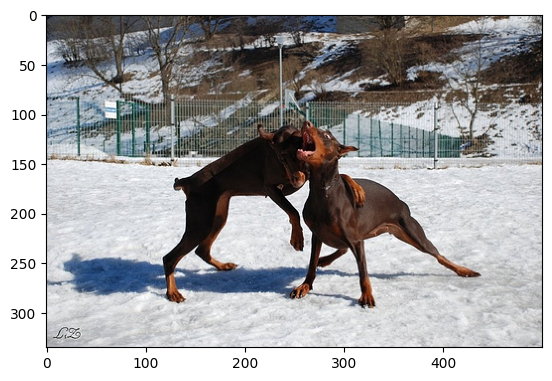

In [55]:
# checking out a predicted/actual caption along with an image used:

print('predicted caption:')
print(lstm_predicted_captions[0])
print('actual captions:')
img_id = os.path.splitext(os.path.basename(testImgsPaths[0]))[0] 
print(testImgToCaptions[img_id])
print('the image itself:')
x = plt.imread(testImgsPaths[0])
plt.imshow(x)
plt.show()

highest rogue score:
0.4150943458080292
its predicted caption:
startseq woman in sunglasses and sunglasses smiles for camera with her hand and woman in hat and sunglasses smiles to camera for picture behind her and woman in black hat and sunglasses smiles for
its actual captions:
['startseq couple practice different ways to wear sunglasses in front of red car endseq', 'startseq girl and boy with sunglasses and red car behind them endseq', 'startseq man with sunglasses and woman with hat are in front of car endseq', 'startseq man with sunglasses on his head is looking at woman with white hat and red scarf next to him whilst standing in front of red sports car endseq', 'startseq woman in crochet hat and sunglasses smiles while man beside her in plaid short and sunglasses looks behind her endseq']
the image itself:


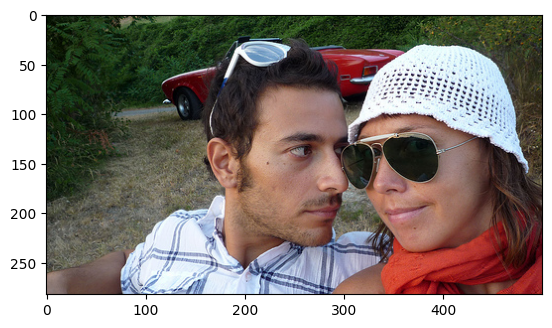

In [56]:
# checking out predicted/actual caption ***of the highest rogue score*** along with the image used:

print('highest rogue score:')
max_lstm_rogue_score = max(lstm_rogue_scores)
print(max_lstm_rogue_score)

argmax_lstm_rogue_score = lstm_rogue_scores.index(max_lstm_rogue_score)
print('its predicted caption:')
print(lstm_predicted_captions[argmax_lstm_rogue_score])
print('its actual captions:')
img_id = os.path.splitext(os.path.basename(testImgsPaths[argmax_lstm_rogue_score]))[0] 
print(testImgToCaptions[img_id])
print('the image itself:')
x = plt.imread(testImgsPaths[argmax_lstm_rogue_score])
plt.imshow(x)
plt.show()

highest bleu score:
0.18356876568357383
its predicted caption:
startseq dog jumps to catch ball in its mouth while two other dogs look on deck deck by man and woman are standing in front of building and stand with balls to them to
its actual captions:
['startseq dog on two legs with its mouth opened toward blue ball in air endseq', 'startseq white dog catching blue ball endseq', 'startseq white dog jumps to catch blue ball in living room endseq', 'startseq dog is jumping in air to catch ball endseq', 'startseq two dogs in family room are playing one is catching ball in its mouth endseq']
the image itself:


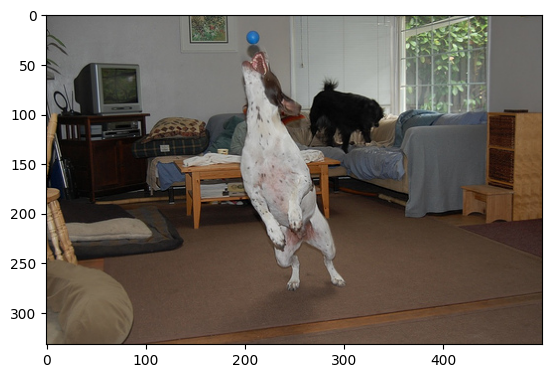

In [57]:
# checking out predicted/actual caption ***of the highest bleu score*** along with the image used:

print('highest bleu score:')
lstm_max_bleu_score = max(lstm_bleu_scores)
print(lstm_max_bleu_score)

argmax_bleu_score = lstm_bleu_scores.index(lstm_max_bleu_score)
print('its predicted caption:')
print(lstm_predicted_captions[argmax_bleu_score])
print('its actual captions:')
img_id = os.path.splitext(os.path.basename(testImgsPaths[argmax_bleu_score]))[0] 
print(testImgToCaptions[img_id])
print('the image itself:')
x = plt.imread(testImgsPaths[argmax_bleu_score])
plt.imshow(x)
plt.show()

## GRU Model

In [59]:
# hyperparameters used when model was trained:
droput_rate = 0.5
dense_layer_units = 256
hidden_layers_activation = 'relu'

current_gru_model = create_gru_model(embedding_matrix, vocabSize, droput_rate, dense_layer_units, hidden_layers_activation)
current_gru_model.load_weights(f'models/gru_models/gru_epochs_of-0030-and_val_loss_of-4.4189.h5')

In [60]:
# rogue and bleu results

# commented out to decrease notebook running time:
gru_rogue_scores, gru_bleu_scores, gru_predicted_captions = calculate_metrics('all', gru_model, testImgsPaths, testImgToFeatures, testImgToCaptions, 
                                                   maxCapLen, lstm_wordToIdx)

current image number: 1
<tf.RaggedTensor [[b'dog', b'is', b'biting', b'another', b'dog', b's', b'mouth', b'open',
  b'in', b'grass', b'next', b'to', b'checkered', b'dog', b'in', b'grass',
  b'next', b'to', b'grass', b'with', b'snow', b'in', b'background',
  b'and', b'black', b'dog', b'is', b'biting', b'another', b'dog', b's',
  b'face']]>
current image number: 2
<tf.RaggedTensor [[b'and', b'two', b'children', b'are', b'playing', b'in', b'water',
  b'with', b'their', b'mouths', b'open', b'and', b'they', b'are', b'all',
  b'in', b'water', b'and', b'one', b'has', b'food', b'drink', b'from',
  b'paddling', b'paddling', b'paddling', b'on', b'water', b'with',
  b'only', b'person', b'in']]>
current image number: 3
<tf.RaggedTensor [[b'of', b'women', b'in', b'bathing', b'suits', b'walk', b'down',
  b'street', b'carrying', b'signs', b'in', b'background', b'and', b'blue',
  b'suits', b'and', b'blue', b'shorts', b'and', b'blue', b'shorts',
  b'and', b'blue', b'shorts', b'and', b'blue', b'shorts',

In [ ]:
pklSave(gru_rogue_scores, './models/gru_30epochs_rogue_scores.pickle')
pklSave(gru_bleu_scores, './models/gru_30epochs_bleu_scores.pickle')
pklSave(gru_predicted_captions, './models/gru_30epochs_predicted_captions.pickle')
gru_rogue_scores = pklLoad('./models/gru_30epochs_rogue_scores.pickle')
gru_bleu_scores = pklLoad('./models/gru_30epochs_bleu_scores.pickle')
gru_predicted_captions = pklLoad('./models/gru_30epochs_predicted_captions.pickle')

In [ ]:
# checking out the average of all scores:
print('average of all rogue scores:')
print(round(sum(gru_rogue_scores) / len(gru_rogue_scores), 5))

# checking out result of 1st test image:
print('1st rogue score:')
print(gru_rogue_scores[0])

print()

# checking out the average of all scores:
print('average of all bleu scores:')
print(round(sum(gru_bleu_scores) / len(gru_bleu_scores), 5))

# checking out result of 1st test image:
print('1st bleu score:')
print(gru_bleu_scores[0])

average of all rogue scores:
0.17871
1st rogue score:
0.22641509771347046

average of all bleu scores:
0.01569
1st bleu score:
1.643961915018504e-78


predicted caption:
startseq dogs are running in a grassy area . a wooded area . a fence . . grabbing . . . . . seen . . seen . . seen . . seen . . seen . . seen . .
actual captions:
['startseq The dogs are in the snow in front of a fence . endseq', 'startseq The dogs play on the snow . endseq', 'startseq Two brown dogs playfully fight in the snow . endseq', 'startseq Two brown dogs wrestle in the snow . endseq', 'startseq Two dogs playing in the snow . endseq']
the image itself:


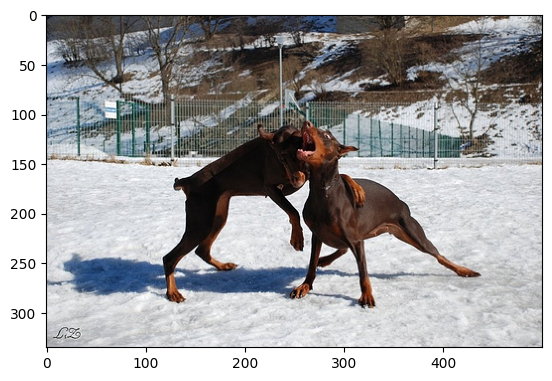

In [ ]:
# checking out a predicted/actual caption along with an image used:

print('predicted caption:')
print(gru_predicted_captions[0])
print('actual captions:')
img_id = os.path.splitext(os.path.basename(testImgsPaths[0]))[0] 
print(testImgToCaptions[img_id])
print('the image itself:')
x = plt.imread(testImgsPaths[0])
plt.imshow(x)
plt.show()

highest rogue score:
0.4333333373069763
its predicted caption:
startseq black and white dog with a blue collar is running through a field . with a stick in its mouth . a second . a blue strip . its mouth . . . . . . . . . .
its actual captions:
['startseq A dog is running with a yellow tennis ball and wearing a red harness . endseq', 'startseq a small black and white dog running through the grass with a tennis ball in his mouth endseq', 'startseq Small black and white dog wearing a red harness is running around with a ball in its mouth . endseq', 'startseq Small dog with red harness fetching a ball . endseq', 'startseq The dog wearing the red collar is running across the grass with a ball in its mouth . endseq']
the image itself:


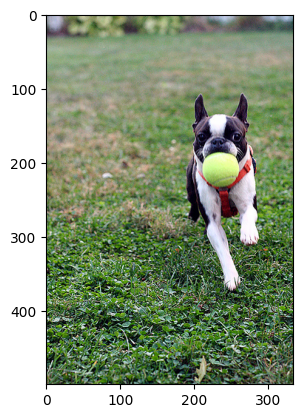

In [ ]:
# checking out predicted/actual caption ***of the highest rogue score*** along with the image used:

print('highest rogue score:')
max_gru_rogue_score = max(gru_rogue_scores)
print(max_gru_rogue_score)

argmax_gru_rogue_score = gru_rogue_scores.index(max_gru_rogue_score)
print('its predicted caption:')
print(gru_predicted_captions[argmax_gru_rogue_score])
print('its actual captions:')
img_id = os.path.splitext(os.path.basename(testImgsPaths[argmax_gru_rogue_score]))[0] 
print(testImgToCaptions[img_id])
print('the image itself:')
x = plt.imread(testImgsPaths[argmax_gru_rogue_score])
plt.imshow(x)
plt.show()

highest bleu score:
0.2134152106157907
its predicted caption:
startseq football player in a white strip is huddled in the middle of a game . . is watched by the player in white . the other team . the other is . the ball . . . . . .
its actual captions:
['startseq a football player in a red jersey getting his knee looked at by another man endseq', 'startseq A man is checking out an injured football player at a game . endseq', 'startseq An injured football player is being nursed on the field in the middle of a game . endseq', 'startseq two men examine a football players leg . endseq', 'startseq Two men help an injured player on the field . endseq']
the image itself:


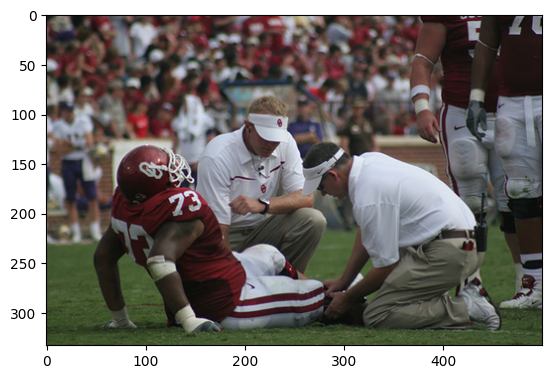

In [ ]:
# checking out predicted/actual caption ***of the highest bleu score*** along with the image used:

print('highest bleu score:')
gru_max_bleu_score = max(gru_bleu_scores)
print(gru_max_bleu_score)

argmax_bleu_score = gru_bleu_scores.index(gru_max_bleu_score)
print('its predicted caption:')
print(gru_predicted_captions[argmax_bleu_score])
print('its actual captions:')
img_id = os.path.splitext(os.path.basename(testImgsPaths[argmax_bleu_score]))[0] 
print(testImgToCaptions[img_id])
print('the image itself:')
x = plt.imread(testImgsPaths[argmax_bleu_score])
plt.imshow(x)
plt.show()

In [56]:
# if you want to check tensorboard logs, run this:
from tensorboard import notebook
notebook.start('--logdir=./models/lstm_logs/ --port 6021')
notebook.start('--logdir=./models/gru_logs/ --port 6022')
# then open these links:
# http://localhost:6021/
# http://localhost:6022/
# Either way, the loss-epochs graphs for both models are in project_media folder